### Import Library


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


## Load Dataset


In [4]:
df_train = pd.read_csv("data/Housing_dataset_train.csv")
df_train.drop('ID', axis=1, inplace=True)
print(df_train.shape)
df_train.head(3)


(14000, 6)


,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,Ekiti,NaN,7.0,5.0,NaN,3364799.814


In [5]:
df_test = pd.read_csv("data/Housing_dataset_test.csv")
df_test.drop('ID', axis=1, inplace=True)
print(df_test.shape)
df_test.head()


(6000, 5)


,loc,title,bedroom,bathroom,parking_space
0,Kano,Penthouse,4,1,2
1,Adamawa,Apartment,2,2,4
2,Adamawa,Bungalow,2,7,2
3,Lagos,Mansion,9,5,2
4,Gombe,Semi-detached duplex,5,6,1


In [6]:
df_test["price"] = "test"


In [7]:
# join test and train data
df = pd.concat([df_train, df_test], axis=0, sort=False)
df.head()


,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [8]:
df.shape


(20000, 6)

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            18187 non-null  object 
 1   title          18278 non-null  object 
 2   bedroom        18201 non-null  float64
 3   bathroom       18195 non-null  float64
 4   parking_space  18189 non-null  float64
 5   price          20000 non-null  object 
dtypes: float64(3), object(3)
memory usage: 1.1+ MB


### Check for missing Values


In [10]:
df_train.isna().sum()

loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [11]:
df.isna().sum()


loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

## Data Preprocessing

### Train-test split

In [52]:
# Divide the dataframe into train and test based on the 'price' column
# df_train = df[~df["price"].astype(str).str.contains("test")]
# df_test = df[df["price"].astype(str).str.contains("test")]

# Reset the index of the dataframes
# df_train = df_train.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)


### Label Encoding

### Filling all missing values


In [53]:
print(df_train['parking_space'].mode()[0])
print(df_test['parking_space'].mode()[0])
print(df['parking_space'].mode()[0])

4.0
2
2.0


In [54]:
df_train.isna().sum() / len(df_train) * 100


loc              12.950000
title            12.300000
bedroom          12.850000
bathroom         12.892857
parking_space    12.935714
price             0.000000
dtype: float64

In [55]:
from sklearn.impute import SimpleImputer

imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp_mode.fit(df_train)

df_train = pd.DataFrame(imp_mode.transform(df_train), columns=df.columns)
df_test = pd.DataFrame(imp_mode.transform(df_test), columns=df.columns)


In [56]:
print(df_train.isna().sum())
print(df_test.isna().sum())

loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
price            0
dtype: int64
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
price            0
dtype: int64


In [57]:
# df["bedroom"] = df["bedroom"].fillna(df["bedroom"].mode()[0])
# df["bathroom"] = df["bathroom"].fillna(df["bathroom"].mode()[0])
# df["parking_space"] = df["parking_space"].fillna(df["parking_space"].mode()[0])
# df["loc"] = df["loc"].fillna(df["loc"].mode()[0])
# df["title"] = df["title"].fillna(df["title"].mode()[0])


### Label Encoding

In [58]:
le = LabelEncoder()

# encode location amd title
for col in ["loc", "title"]:
    le = le.fit(df_train[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
df_train.head()

,loc,title,bedroom,bathroom,parking_space,price
0,19,7,2.0,2.0,1.0,1149999.565
1,27,0,5.0,2.0,4.0,1672416.689
2,12,4,7.0,5.0,4.0,3364799.814
3,3,3,5.0,2.0,4.0,2410306.756
4,21,8,5.0,5.0,6.0,2600700.898


In [59]:
df_test.head()

,loc,title,bedroom,bathroom,parking_space,price
0,18,6,4,1,2,test
1,1,0,2,2,4,test
2,1,1,2,7,2,test
3,23,5,9,5,2,test
4,14,7,5,6,1,test


## Model

In [60]:
print(df_train.shape, df_test.shape)


(14000, 6) (6000, 6)


### Scaling of dataset


In [61]:
X = df_train.drop("price", axis=1)
y = df_train["price"].astype(float)
X_test = df_test.drop("price", axis=1)
y_test = df_test["price"]


In [62]:
# scale the dataset with standard scaler

scaler = StandardScaler()
train_scaler = scaler.fit(X)
X = train_scaler.transform(X)
# scaler.fit(X_test)
X_test = train_scaler.transform(X_test)


In [122]:
x_cols = df_train.columns[0:-1]
print(x_cols)
X = pd.DataFrame(X, columns=x_cols)
X.head()

Index(['loc', 'title', 'bedroom', 'bathroom', 'parking_space'], dtype='object')


,loc,title,bedroom,bathroom,parking_space
0,0.163812,0.892289,-1.046498,-0.423135,-1.500034
1,0.990773,-1.688331,0.263223,-0.423135,0.476110
2,-0.559779,-0.213691,1.136369,1.054513,0.476110
3,-1.490110,-0.582351,0.263223,-0.423135,0.476110
4,0.370552,1.260949,0.263223,1.054513,1.793539


In [123]:
# split dataset

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=7)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)


(10500, 5) (3500, 5)
(10500,) (3500,)


### Model Creation


In [64]:
def fit_score(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=7)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = round(mean_squared_error(y_val, y_pred, squared=False))
    print(f"RMSE: {rmse:,}")
    
    model.fit(X,y)
    return model

### RandomForestRegressor

In [65]:
# Create a linear regression model
from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor()

# # Fit the model to the training data
# model.fit(X_train, y_train)

# # Predict the target variable for the test data
# y_pred = model.predict(X_val)

# rmse = round(mean_squared_error(y_val, y_pred, squared=False))
# print(f"RMSE: {rmse:,}")


In [66]:
rf_model = fit_score(RandomForestRegressor(), X, y)
predictions = rf_model.predict(X_test)

RMSE: 648,324


In [67]:
sample_sub = pd.read_csv('data/Sample_submission.csv')
print(sample_sub.shape)
sample_sub.head()

(6000, 1)


,ID
0,845
1,1924
2,10718
3,12076
4,12254


In [68]:
sample_sub['price'] = predictions
sample_sub.to_csv('submissions/rf_regression_sub.csv', index=False)
sample_sub.head()

,ID,price
0,845,2.395405e+06
1,1924,1.038551e+06
2,10718,1.357044e+06
3,12076,8.007182e+06
4,12254,1.974406e+06


### Model Evaluation


we evaluate the performance of the regression model by visually inspecting the predicted values and comparing them to the actual values in the training data since theres no test data.
This will create a scatter plot of the predicted values versus the actual values in the training data.
A good regression model will have the predicted values close to the actual values along the diagonal line.


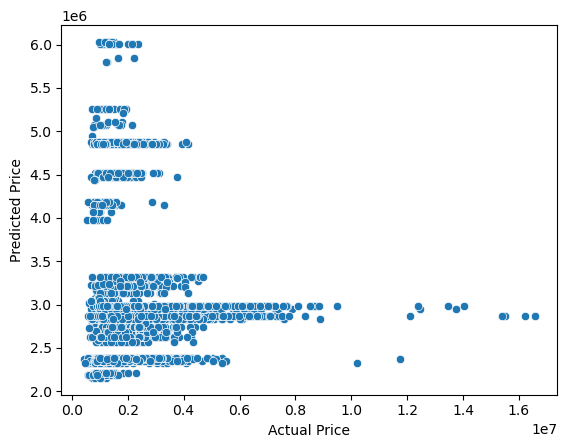

In [69]:
# Create a scatter plot of the predicted vs actual values
sns.scatterplot(x=df_train["price"], y=rf_model.predict(df_train.drop("price", axis=1)))
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show() 


### Improving model performance


### Ridge regularization


In [70]:
from sklearn.linear_model import Ridge

# Create a Ridge regression model with a regularization strength of 0.1
model = Ridge(alpha=0.1)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = model.predict(X_val)

# Calculate the RMSE of the model on the validation data
rmse = round(mean_squared_error(y_val, y_pred, squared=False))
print(f"RMSE: {rmse:,}")


RMSE: 919,332


### hyper parameter tuning


In [71]:
# Define the hyperparameters to tune
# param_grid = {
#     "ridge__alpha": [0.1, 1, 10, 100],
#     "ridge__fit_intercept": [True, False],
#     "polynomialfeatures__degree": [1, 2, 3],
# }

# # Create a Ridge regression model
# model = make_pipeline(PolynomialFeatures(), Ridge())

# # Create a grid search object
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_error")

# # Fit the grid search object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and the corresponding score
# print("Best hyperparameters:", grid_search.best_params_)
# print("Best score:", f"{-grid_search.best_score_:,.0f}")


In [72]:
# # Create a Ridge regression model with the best hyperparameters
# model = make_pipeline(
#     PolynomialFeatures(degree=grid_search.best_params_["polynomialfeatures__degree"]),
#     Ridge(
#         alpha=grid_search.best_params_["ridge__alpha"],
#         fit_intercept=grid_search.best_params_["ridge__fit_intercept"],
#     ),
# )

# # Train the model on the entire training set
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_val)

# # Calculate the RMSE of the model on the test set
# rmse = mean_squared_error(y_val, y_pred, squared=False)

# print("RMSE:", f"{rmse:,.0f}")


### GradientBoostingRegressor

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = fit_score(GradientBoostingRegressor(random_state=42), X, y)

RMSE: 580,149


### Hyperparemeter tuning

In [74]:
# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 1],
}

# Create a Gradient Boosting model
model = GradientBoostingRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    model, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding RMSE score
print("Best hyperparameters:", grid_search.best_params_)
print("RMSE score:", f"{ -grid_search.best_score_:,.0f}")

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
RMSE score: 548,323


In [75]:
# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [150, 200, 125],
    "max_depth": [4, 5, 6],
    "learning_rate": [0.01, 0.1, 1],
}

# Create a Gradient Boosting model
model = GradientBoostingRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    model, param_grid, cv=10, scoring="neg_root_mean_squared_error", n_jobs=-1
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding RMSE score
print("Best hyperparameters:", grid_search.best_params_)
print("RMSE score:", f"{ -grid_search.best_score_:,.0f}")

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
RMSE score: 545,088


In [77]:
# def fn(**grid_search.best_params_):
#     return grid_search.best_params_

In [78]:
gb_model = fit_score(
    GradientBoostingRegressor(random_state=42, **grid_search.best_params_), X, y
)


RMSE: 541,897


In [79]:
predictions = gb_model.predict(X_test)

sample_sub['price'] = predictions
sample_sub.to_csv('submissions/gb_regressor_tuned_sub.csv', index=False)
sample_sub.head()

# 362891.4090 on LB

,ID,price
0,845,2.384743e+06
1,1924,1.002625e+06
2,10718,1.137690e+06
3,12076,8.980261e+06
4,12254,1.851039e+06


### KFold Cross Validation Gradient Boosting Regressor

In [99]:
from sklearn.model_selection import KFold

rmse_list = []
test_preds = []

# create a StratifiedKFold object
kf = KFold(n_splits=10, shuffle=True, random_state=200)

# create a GradientBoostingRegressor object
gbr = GradientBoostingRegressor(random_state=4220, **grid_search.best_params_)

# iterate over the folds
for i, (train_index, val_index) in enumerate(kf.split(X, y)):
    # split the data into training and valing sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # fit the model on the training data
    gbr.fit(X_train, y_train)
    
    y_pred = gbr.predict(X_val)
    
    # evaluate the model on the validation data
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmse_list.append(rmse)
    
    # print the score for each fold
    print(f"Fold {i+1} RMSE: {rmse:,.0f}")
    print("======="*10)
    
    preds = gbr.predict(X_test)
    test_preds.append(preds)
    
print(f"Average RMSE: {np.mean(rmse_list):,.0f}")

Fold 1 RMSE: 586,193
Fold 2 RMSE: 603,470
Fold 3 RMSE: 506,458
Fold 4 RMSE: 494,880
Fold 5 RMSE: 473,286
Fold 6 RMSE: 587,637
Fold 7 RMSE: 637,414
Fold 8 RMSE: 482,357
Fold 9 RMSE: 553,161
Fold 10 RMSE: 519,910
Average RMSE: 544,477


In [107]:
X_test

array([[ 0.06044198,  0.52362886, -0.17335081, -0.91568488, -0.84131972],
       [-1.69684984, -1.68833112, -1.04649755, -0.42313528,  0.47610951],
       [-1.69684984, -1.31967112, -1.04649755,  2.03961269, -0.84131972],
       ...,
       [ 1.19751316,  1.62960885, -0.17335081, -0.91568488,  0.47610951],
       [-1.38673952, -0.21369113, -0.60992418,  2.03961269,  1.13482413],
       [ 1.50762348,  0.15496886,  0.69979592, -0.91568488,  1.79353874]])

In [116]:
type(X)

numpy.ndarray

In [136]:
from sklearn.model_selection import KFold
from typing import List

sns.set()

def fold_fit_score(model, X: pd.DataFrame, y: pd.Series, n_folds: int, plot_feat_imp=False) -> List[list]:
    rmse_list_transformed = []
    test_preds_transformed = []

    # create a StratifiedKFold object
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=20)

    # iterate over the folds
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):
        # split the data into training and valing sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = np.log1p(y[train_index].astype(float)), y[val_index]

        # fit the model on the training data
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        # evaluate the model on the validation data
        rmse = mean_squared_error(y_val, np.expm1(y_pred), squared=False)
        rmse_list_transformed.append(rmse)

        # print the score for each fold
        print(f"Fold {i+1} RMSE: {rmse:,.0f}")
        print("=======" * 10)

        preds = model.predict(X_test)
        test_preds_transformed.append(np.expm1(preds))

    print(f"Average RMSE: {np.mean(rmse_list_transformed):,.0f}")
    
    if plot_feat_imp:
        # feature importance plot for model
        feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
        feat_imp = feat_imp.sort_values(by='Importance', ascending=False).reset_index(drop=True)
        # feat_imp = feat_imp.iloc[:20]
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feat_imp)
        plt.title(f'Feature Importance for {type(model).__name__}')
        plt.show()

    return test_preds_transformed

Fold 1 RMSE: 470,504
Fold 2 RMSE: 538,007
Fold 3 RMSE: 632,338
Fold 4 RMSE: 498,295
Fold 5 RMSE: 518,676
Fold 6 RMSE: 591,267
Fold 7 RMSE: 573,258
Fold 8 RMSE: 566,018
Fold 9 RMSE: 482,011
Fold 10 RMSE: 606,466
Average RMSE: 547,684


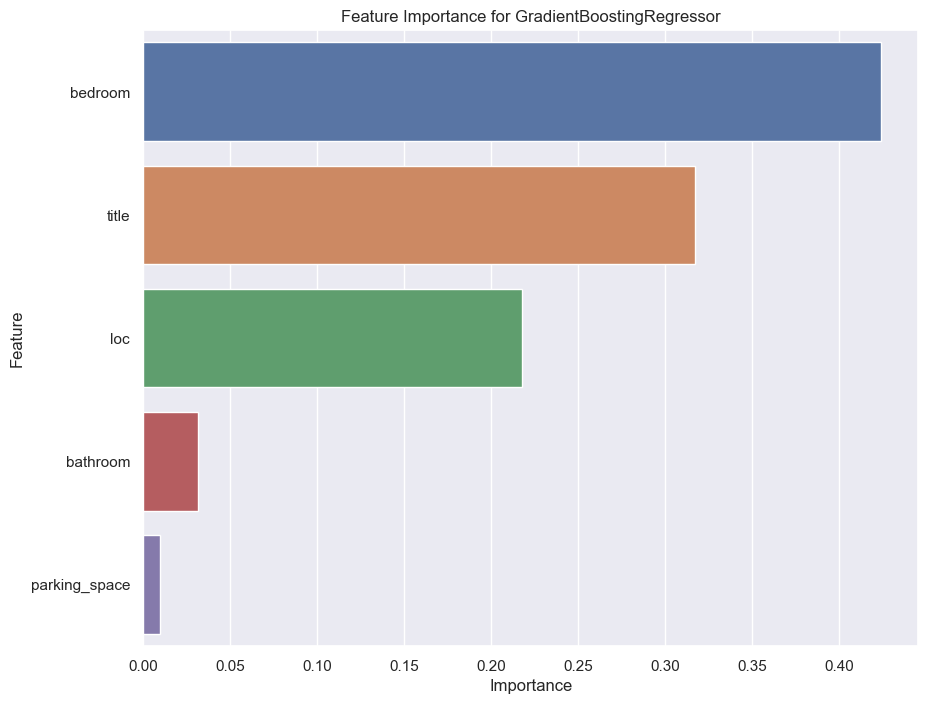

In [138]:
gbr_preds = fold_fit_score(gbr, X, y, 10, plot_feat_imp=True)

In [119]:
gbr_preds[0]

array([2390414.87903695, 1038576.69875783, 1148161.70946006, ...,
       1972654.99697293, 1643041.10442364, 3280089.14013022])

In [114]:
sample_sub['price'] = np.mean(gbr_preds, axis=0)
sample_sub.to_csv('submissions/gb_regressor_tuned_kfold_10_transformed.csv', index=False)
sample_sub.head()

,ID,price
0,845,2.378471e+06
1,1924,1.037658e+06
2,10718,1.138872e+06
3,12076,8.519338e+06
4,12254,1.824303e+06


### CatBoostRegressor

Fold 1 RMSE: 491,739
Fold 2 RMSE: 433,718
Fold 3 RMSE: 591,946
Fold 4 RMSE: 477,285
Fold 5 RMSE: 706,070
Fold 6 RMSE: 511,395
Fold 7 RMSE: 493,045
Fold 8 RMSE: 533,904
Fold 9 RMSE: 639,074
Fold 10 RMSE: 646,331
Fold 11 RMSE: 495,843
Fold 12 RMSE: 596,313
Fold 13 RMSE: 468,185
Fold 14 RMSE: 490,612
Fold 15 RMSE: 670,452
Average RMSE: 549,728


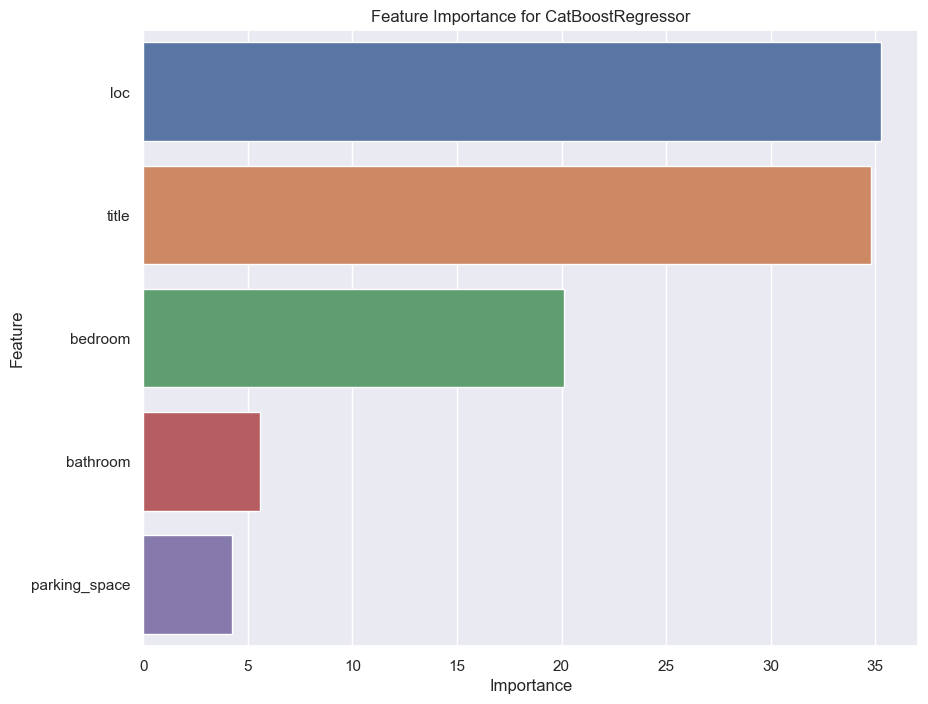

In [139]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=10,
    loss_function="RMSE",
    random_seed=419,
    verbose=False,
)

cb_preds = fold_fit_score(cb, X, y, 15, plot_feat_imp=True)

# LB Score: 370764.5299

In [140]:
sample_sub['price'] = np.mean(cb_preds, axis=0)
sample_sub.to_csv('submissions/catboost_regressor_kfold_15_transformed.csv', index=False)
sample_sub.head()

,ID,price
0,845,2.382314e+06
1,1924,1.020772e+06
2,10718,1.227334e+06
3,12076,8.286280e+06
4,12254,1.817707e+06


In [76]:
# from sklearn.preprocessing import PolynomialFeatures

# # Create polynomial features
# poly = PolynomialFeatures(degree=4)
# X_train_poly = poly.fit_transform(X_train)
# X_val_poly = poly.transform(X_val)

# # Define the hyperparameters to tune
# param_grid = {
#     "n_estimators": [150, 200, 125],
#     "max_depth": [4, 5, 6],
#     "learning_rate": [0.01, 0.1, 1],
# }

# # Create a Gradient Boosting model
# model = GradientBoostingRegressor()

# # Create a GridSearchCV object
# grid_search = GridSearchCV(
#     model, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
# )

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train_poly, y_train)

# # Print the best hyperparameters and the corresponding RMSE score
# print("Best hyperparameters:", grid_search.best_params_)
# print("RMSE score:", -grid_search.best_score_)

### Cross Validation

In [80]:
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)

# Create a Gradient Boosting model
model = GradientBoostingRegressor()

# Create a BaggingRegressor model with the Gradient Boosting model as the base estimator
bagging_model = BaggingRegressor(base_estimator=model, n_estimators=10)

# Fit the model to the training data
bagging_model.fit(X_train_poly, y_train)

# Predict the target variable for the test data
y_pred = bagging_model.predict(X_val_poly)


In [81]:
mean_squared_error(y_val, y_pred, squared=False)

561734.8952800276